<a href="https://colab.research.google.com/github/Czedros/CSE352-Machine-Learning-Assignments/blob/main/CSE352MidtermMakeupAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Name: [Enter Here]

I understand that my submission needs to be my own work: [Initials]

I understand that ChatGPT / Copilot / other AI tools are not allowed:  [Initials]

Total Points: **75**

Complete this notebook and submit it (save/print as pdf). Make sure all output is correct in the pdf before submitting (it sometimes gets cut off).

 The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Overview

In this assignment, you will:
- Implement the rules and structure for Ultimate Tic-Tac-Toe
- Design a basic Monte Carlo Tree Search (MCTS) agent
- Use MCTS to play against a human in the command line

#Setup

To start this assignemnt, We first install a few neccesary Packages.

In [ ]:
!pip install numpy

#Ultimate Tic-Tac-Toe

Ultimate Tic-Tac-Toe is a strategic extension of the classic Tic-Tac-Toe game. Rather than a single 3×3 grid, Ultimate Tic-Tac-Toe consists of a 3×3 grid where each cell contains another 3×3 Tic-Tac-Toe board. This layered setup creates a more complex game structure requiring players to think multiple moves ahead.

The game was first popularized online in the early 2010s and is designed to emphasize positional play, long-term strategy, and adaptation to an evolving board state. Each player, X or O, takes turns placing their mark in a cell of one of the smaller boards. However, the twist lies in the move constraints: a player’s move determines which of the nine small boards their opponent must play in next. Specifically, if a player places their mark in cell (i, j) of a small board, their opponent must play in the (i, j) small board on their next turn.

The objective is to win the larger game by winning three small boards in a row—horizontally, vertically, or diagonally—similar to classic Tic-Tac-Toe. A small board is won when a player has three marks in a row within it. If a player is sent to a board that is already won or drawn, they may play in any open board of their choosing.

Ultimate Tic-Tac-Toe presents a more intricate challenge than its predecessor and is a rich environment for studying game trees, simulation-based planning, and reinforcement learning. For more information about the game and strategic insights, refer to its [Wikipedia page](https://en.wikipedia.org/wiki/Ultimate_tic-tac-toe).

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_ultimate_board(board, highlight=None):
    """
    Visualizes a 9x9 Ultimate Tic-Tac-Toe board.

    board: 9x9 numpy array with values 0 (empty), 1 (X), 2 (O)
    highlight: (row, col) tuple of active small board (0-2, 0-2)
    """
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)

    # Draw grid
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', lw=lw)
        ax.axvline(i, color='black', lw=lw)

    # Draw pieces
    for row in range(9):
        for col in range(9):
            val = board[row, col]
            if val == 1:
                ax.text(col+0.5, 8.5-row, 'X', ha='center', va='center', fontsize=16)
            elif val == 2:
                ax.text(col+0.5, 8.5-row, 'O', ha='center', va='center', fontsize=16)

    # Highlight the active board
    if highlight:
        y, x = highlight
        rect = patches.Rectangle((x*3, 9-(y+1)*3), 3, 3, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.show()


An usage of the visualizer code.

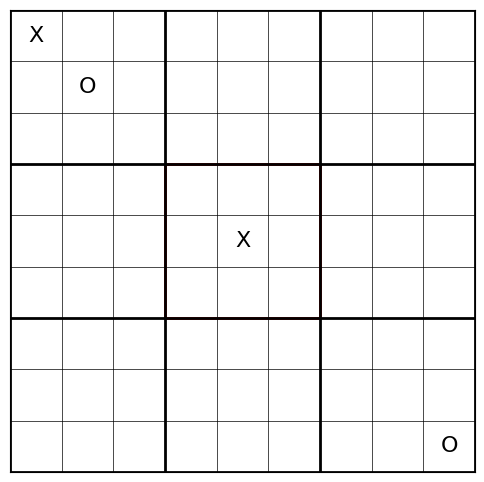

In [27]:
# Example board
board = np.zeros((9, 9), dtype=int)
board[0, 0] = 1
board[1, 1] = 2
board[4, 4] = 1
board[8, 8] = 2

draw_ultimate_board(board, highlight=(1, 1))

#Part 1: Ultimate Tic-Tac-Toe [X Points]
In the first part, you will implement the mechanics of Ultimate Tic-Tac-Toe, defining how the game progresses and determining legal moves and win conditions.

This includes
-

In [11]:
import numpy as np

class SmallBoard:
    def __init__(self):
        self.grid = np.zeros((3, 3), dtype=int)  # 0 = empty, 1 = X, 2 = O
        self.winner = 0  # 0 = no one, 1 = X, 2 = O, -1 = tie
        self.active = True

    def play_move(self, row, col, player):
        if self.grid[row, col] != 0 or not self.active:
            return False
        self.grid[row, col] = player
        self.check_winner()
        return True

    def check_winner(self):
        for i in range(3):
            if np.all(self.grid[i, :] == self.grid[i, 0]) and self.grid[i, 0] != 0:
                self._declare_winner(self.grid[i, 0])
                return
            if np.all(self.grid[:, i] == self.grid[0, i]) and self.grid[0, i] != 0:
                self._declare_winner(self.grid[0, i])
                return
        if np.all(np.diag(self.grid) == self.grid[0, 0]) and self.grid[0, 0] != 0:
            self._declare_winner(self.grid[0, 0])
            return
        if np.all(np.diag(np.fliplr(self.grid)) == self.grid[0, 2]) and self.grid[0, 2] != 0:
            self._declare_winner(self.grid[0, 2])
            return
        if np.all(self.grid != 0):
            self._declare_winner(-1)

    def _declare_winner(self, winner):
        self.winner = winner
        self.active = False


In [12]:
import numpy as np
import random

class UltimateBoard:
    def __init__(self):
        self.boards = [[SmallBoard() for _ in range(3)] for _ in range(3)]
        self.current_player = 1  # 1 = X, 2 = O
        self.next_board = None  # (row, col) of next board; None means any active board
        self.global_winner = 0

    def play_move(self, big_r, big_c, small_r, small_c):
        board = self.boards[big_r][big_c]
        if self.next_board and (big_r, big_c) != self.next_board:
            print("You must play in board", self.next_board)
            return False
        if not board.play_move(small_r, small_c, self.current_player):
            print("Invalid move.")
            return False

        # Update next board
        next_r, next_c = small_r, small_c
        if self.boards[next_r][next_c].active:
            self.next_board = (next_r, next_c)
        else:
            self.next_board = None  # Any active board

        # Check for global win
        self.check_global_winner()

        # Swap player
        self.current_player = 3 - self.current_player
        return True

    def check_global_winner(self):
        grid = np.array([[b.winner if b.winner > 0 else 0 for b in row] for row in self.boards])
        for i in range(3):
            if np.all(grid[i, :] == grid[i, 0]) and grid[i, 0] != 0:
                self.global_winner = grid[i, 0]
                return
            if np.all(grid[:, i] == grid[0, i]) and grid[0, i] != 0:
                self.global_winner = grid[0, i]
                return
        if np.all(np.diag(grid) == grid[0, 0]) and grid[0, 0] != 0:
            self.global_winner = grid[0, 0]
            return
        if np.all(np.diag(np.fliplr(grid)) == grid[0, 2]) and grid[0, 2] != 0:
            self.global_winner = grid[0, 2]
            return

    def get_legal_moves(self):
        moves = []
        for big_r in range(3):
            for big_c in range(3):
                board = self.boards[big_r][big_c]
                if self.next_board and (big_r, big_c) != self.next_board:
                    continue
                if board.active:
                    for i in range(3):
                        for j in range(3):
                            if board.grid[i, j] == 0:
                                moves.append((big_r, big_c, i, j))
        return moves

    def display(self):
        # Display the full board in CLI format
        def cell_symbol(val):
            return '.' if val == 0 else ('X' if val == 1 else 'O')

        for big_r in range(3):
            for r in range(3):
                line = ''
                for big_c in range(3):
                    board = self.boards[big_r][big_c]
                    line += ' '.join(cell_symbol(board.grid[r, c]) for c in range(3)) + ' | '
                print(line)
            print('-' * 20)


In [28]:

def draw_ultimate_board(game):
    """
    Draws the full Ultimate Tic-Tac-Toe board from an UltimateBoard object.
    Includes highlight for next required board if applicable.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)

    # Draw grid
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax.axhline(i, color='black', lw=lw)
        ax.axvline(i, color='black', lw=lw)

    # Draw pieces
    for br in range(3):
        for bc in range(3):
            board = game.boards[br][bc]
            for r in range(3):
                for c in range(3):
                    val = board.grid[r, c]
                    if val == 1:
                        symbol = 'X'
                    elif val == 2:
                        symbol = 'O'
                    else:
                        continue
                    gx = bc * 3 + c
                    gy = 8 - (br * 3 + r)
                    ax.text(gx + 0.5, gy + 0.5, symbol, ha='center', va='center', fontsize=16)

    # Highlight the active board
    if game.next_board:
        y, x = game.next_board
        rect = patches.Rectangle((x * 3, 9 - (y + 1) * 3), 3, 3, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.show()


Current Turn: Player X


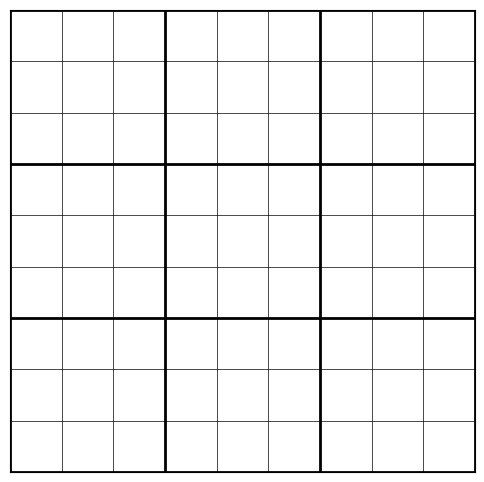

You may play in any active board.
Enter your move (big_r big_c small_r small_c): 1 1 1 1 

Current Turn: Player O


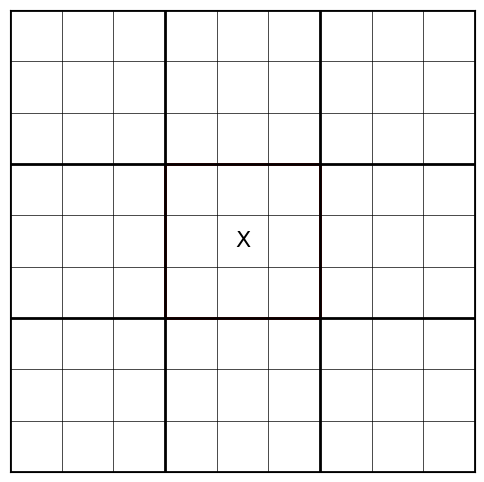

You must play in small board: (1, 1)
Bot plays: (1, 1, 0, 0)

Current Turn: Player X


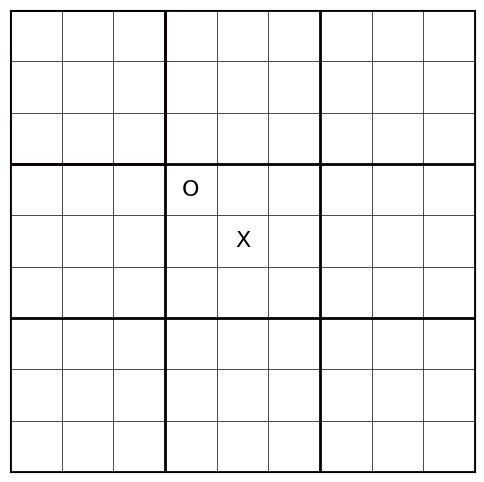

You must play in small board: (0, 0)


KeyboardInterrupt: Interrupted by user

In [29]:
def random_bot(board: UltimateBoard):
    return random.choice(board.get_legal_moves())

def play_game():
    game = UltimateBoard()
    while not game.global_winner and game.get_legal_moves():
        print("\nCurrent Turn: Player {}".format("X" if game.current_player == 1 else "O"))
        draw_ultimate_board(game)

        if game.next_board:
          print("You must play in small board:", game.next_board)
        else:
          print("You may play in any active board.")

        if game.current_player == 1:
            move = input("Enter your move (big_r big_c small_r small_c): ").split()
            try:
                move = tuple(map(int, move))
                if len(move) != 4 or not game.play_move(*move):
                    print("Try again.")
            except:
                print("Invalid input.")
        else:
            move = random_bot(game)
            print(f"Bot plays: {move}")
            game.play_move(*move)

    print("\nFinal Result:")
    draw_ultimate_board(game)
    if game.global_winner:
        print("Winner: Player", "X" if game.global_winner == 1 else "O")
    else:
        print("Game ended in a draw.")
play_game()


#Part 2: Monte Carlo Tree Search